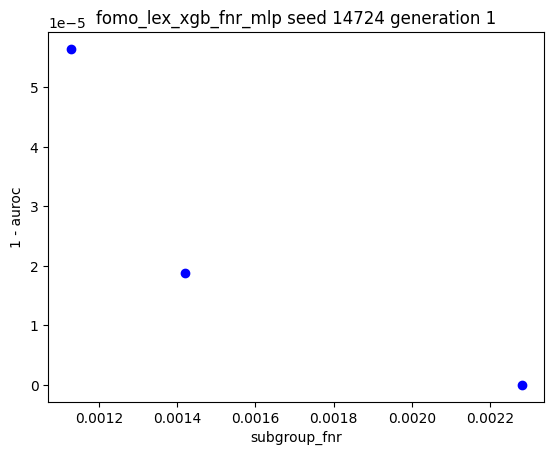

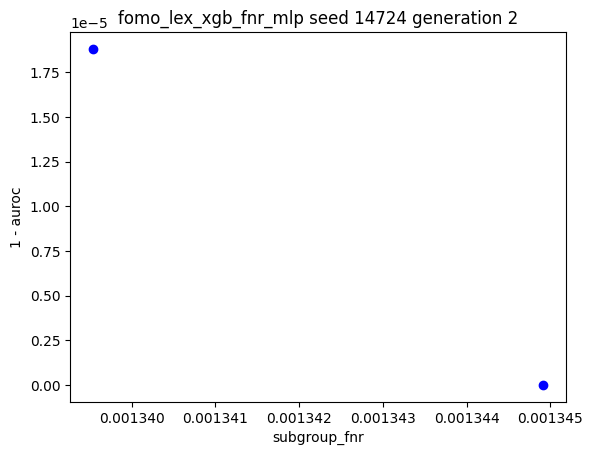

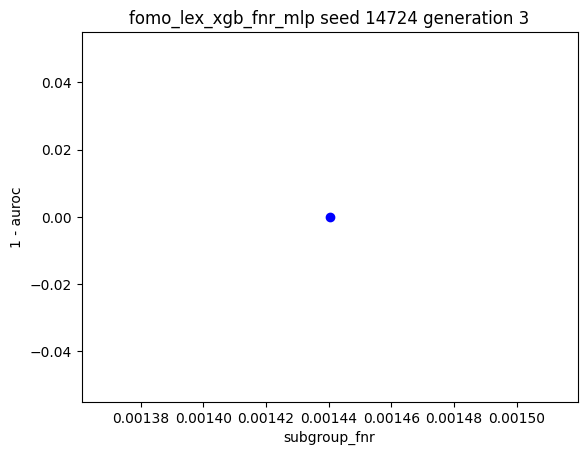

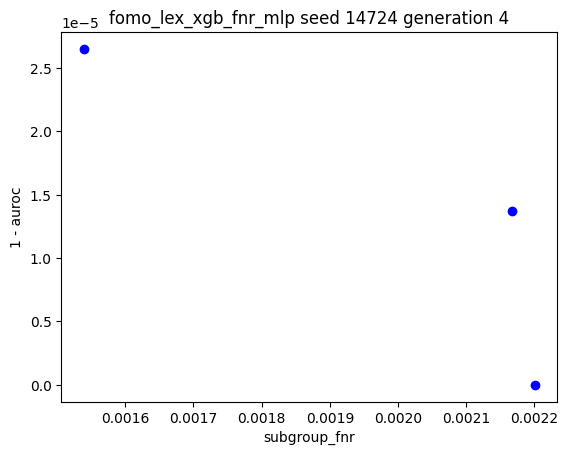

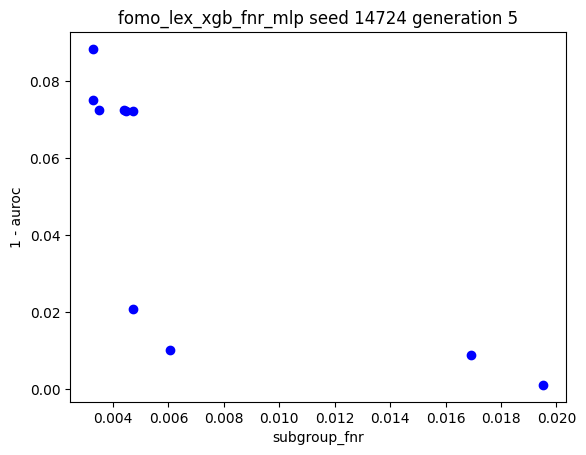

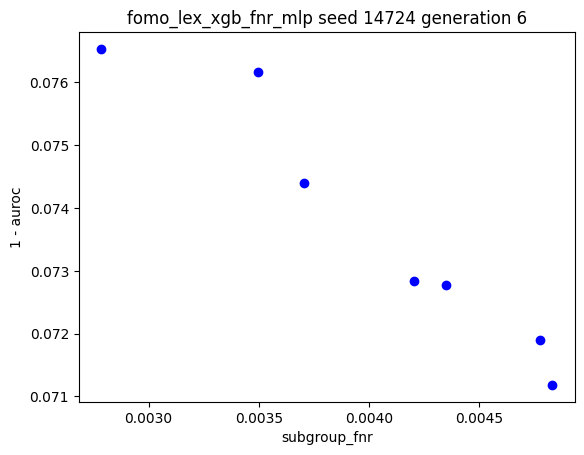

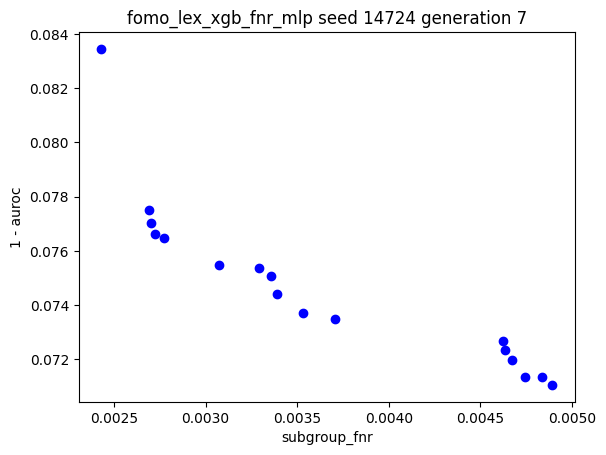

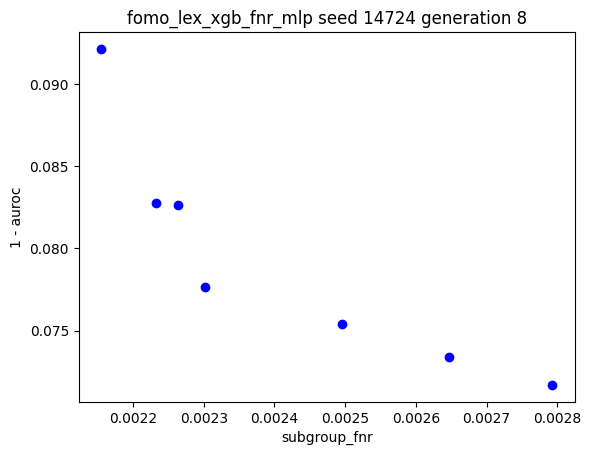

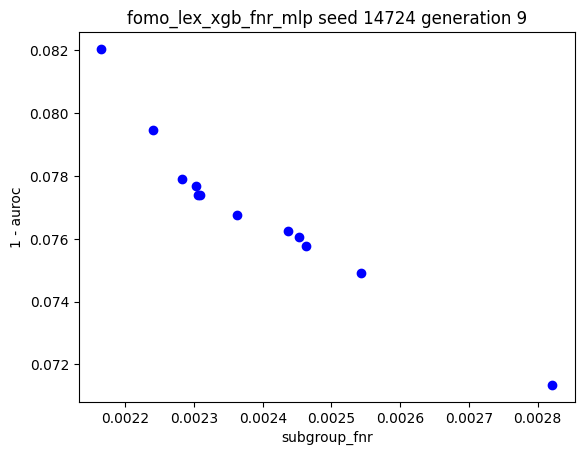

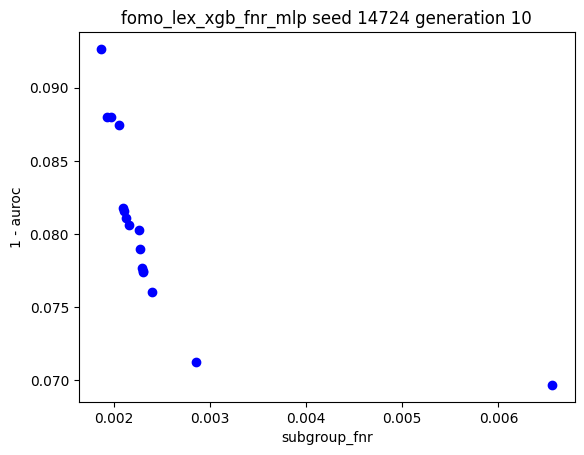

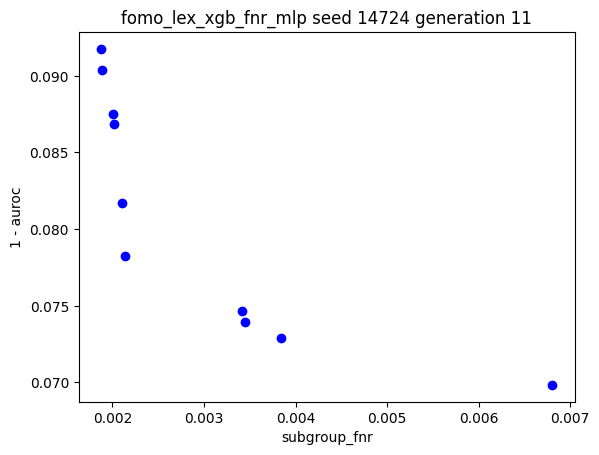

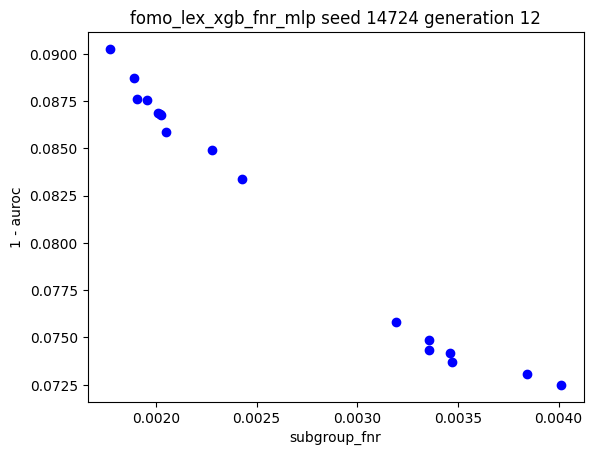

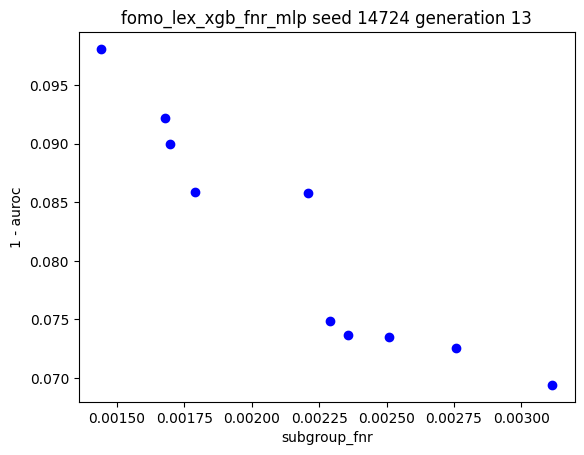

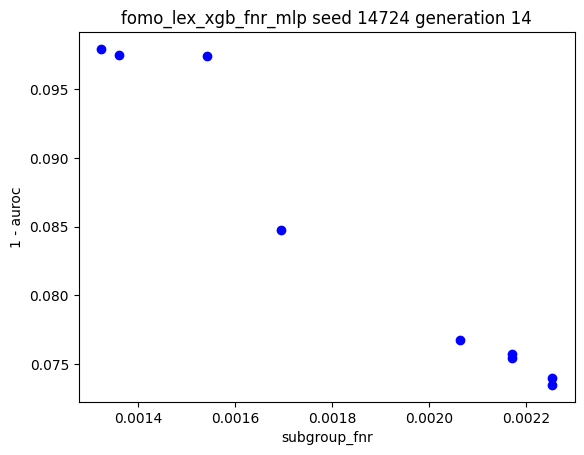

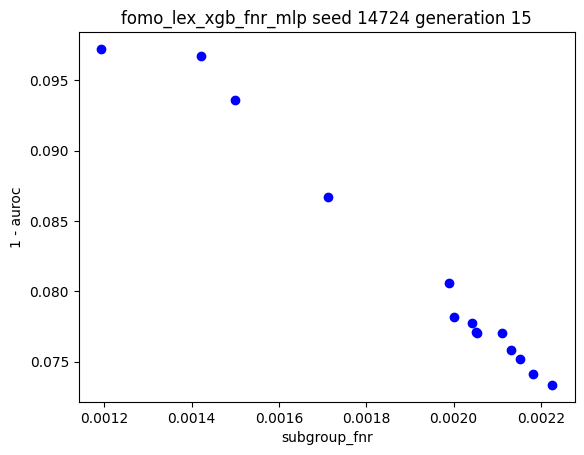

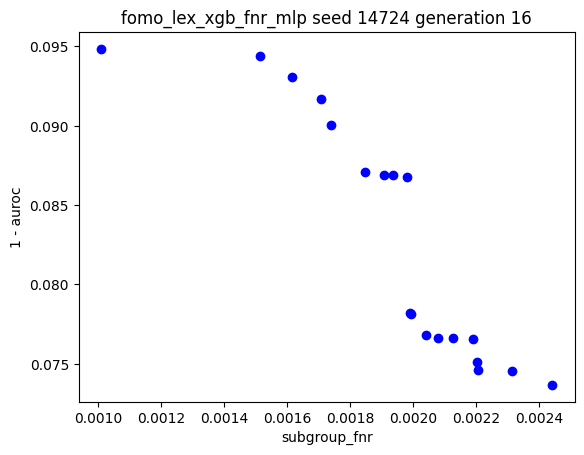

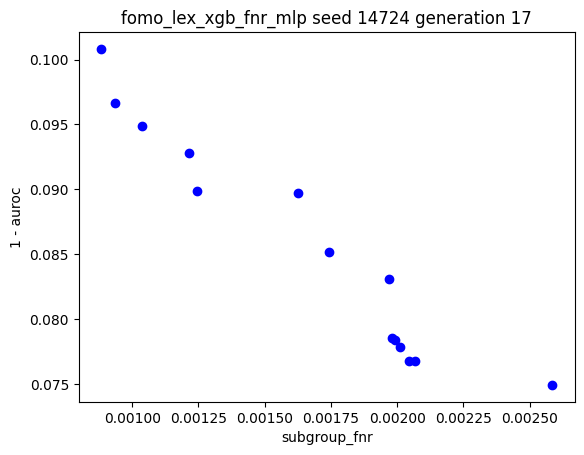

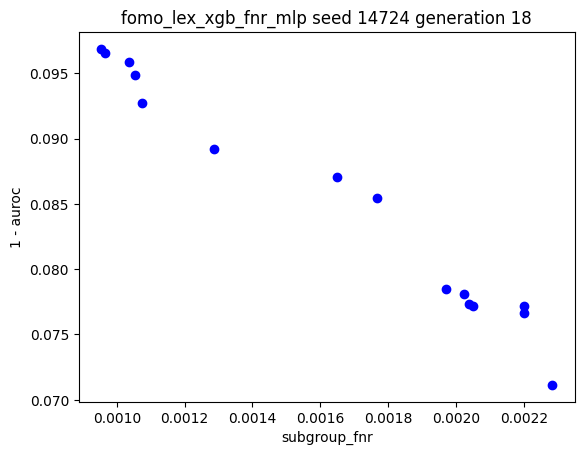

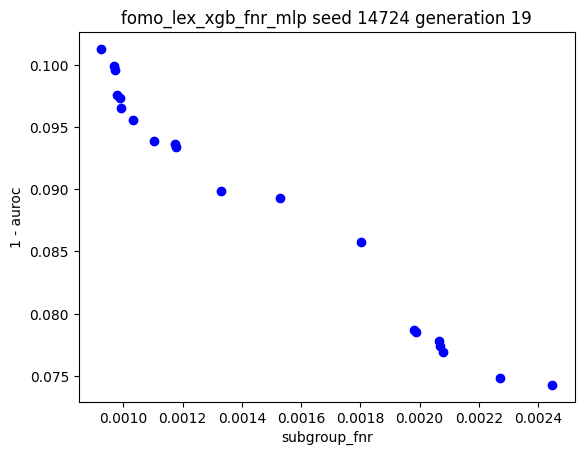

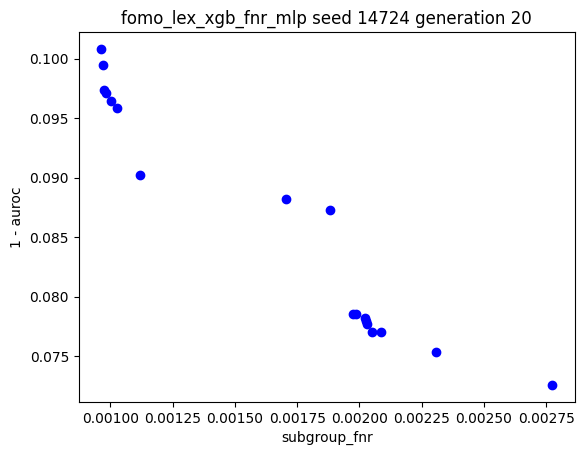

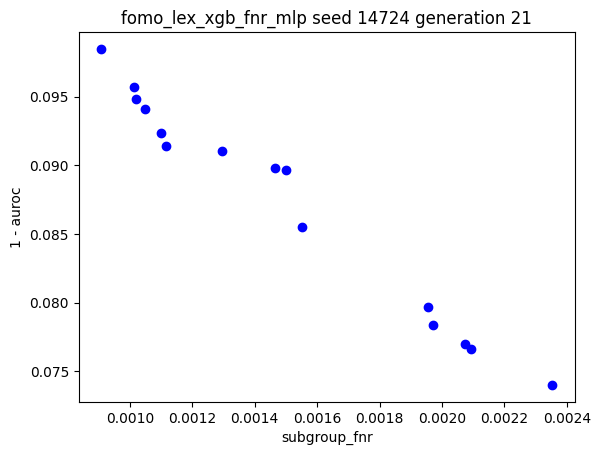

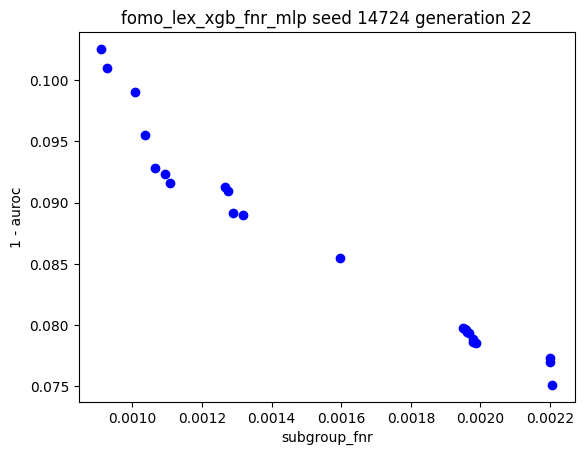

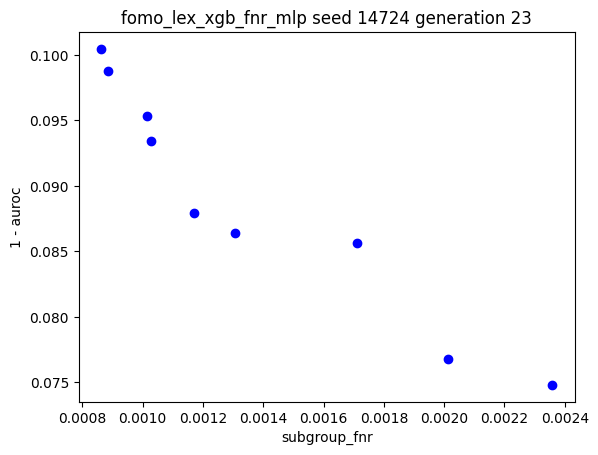

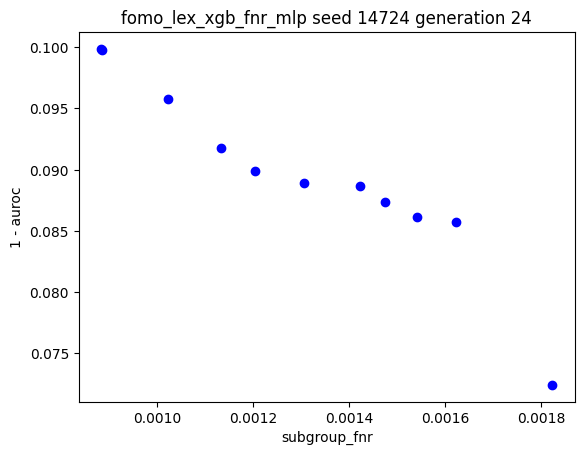

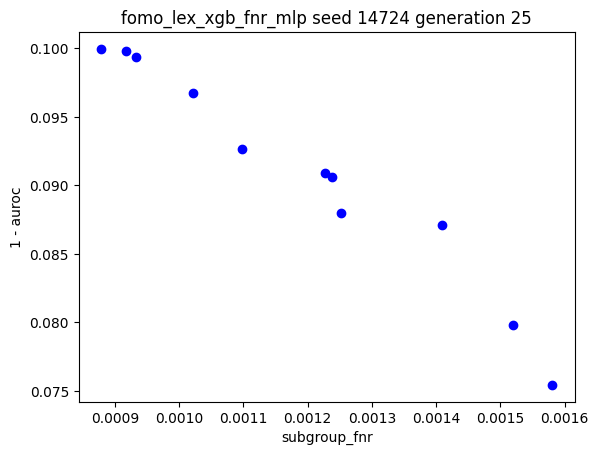

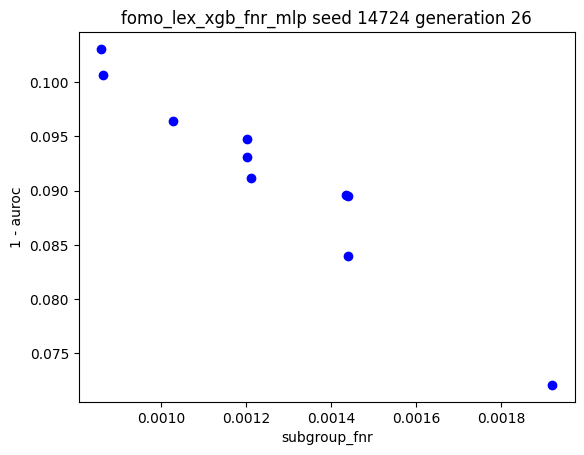

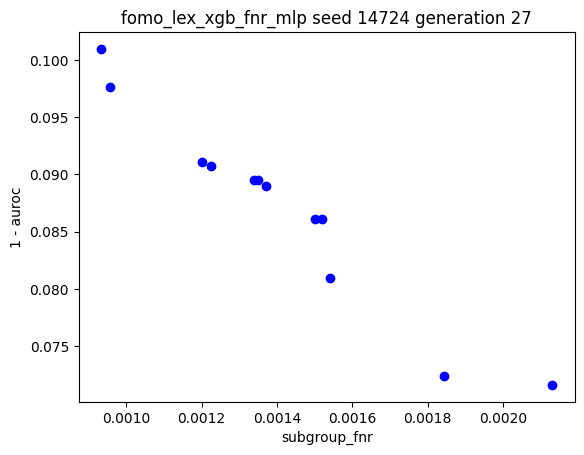

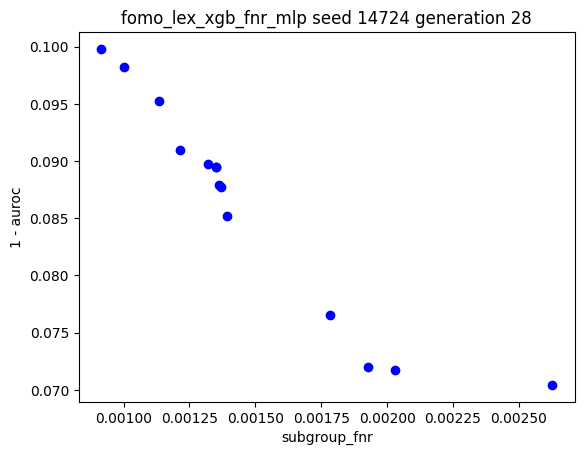

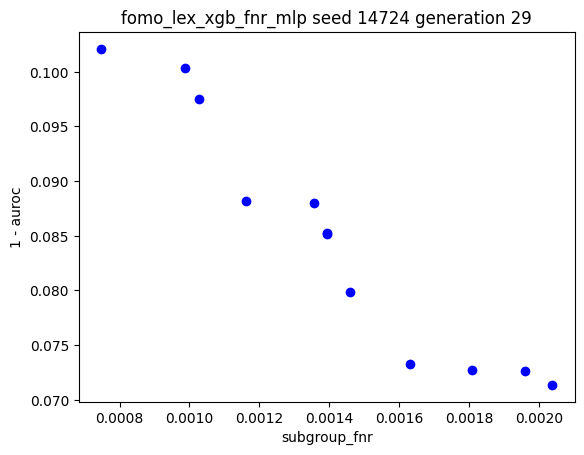

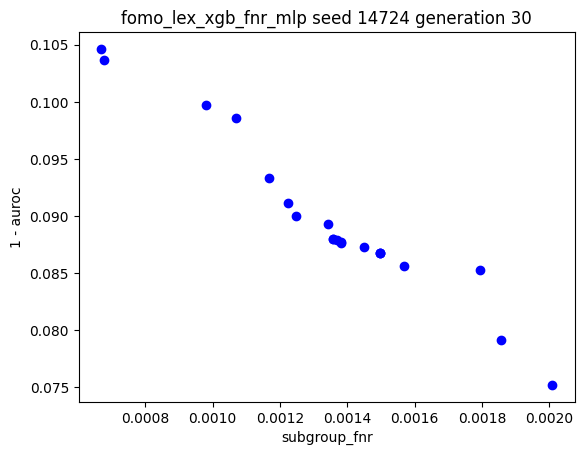

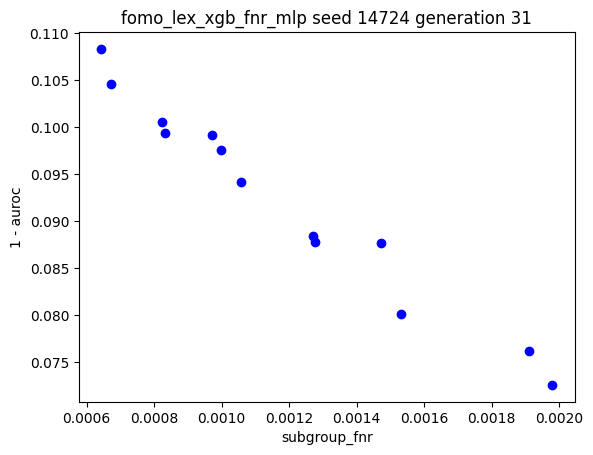

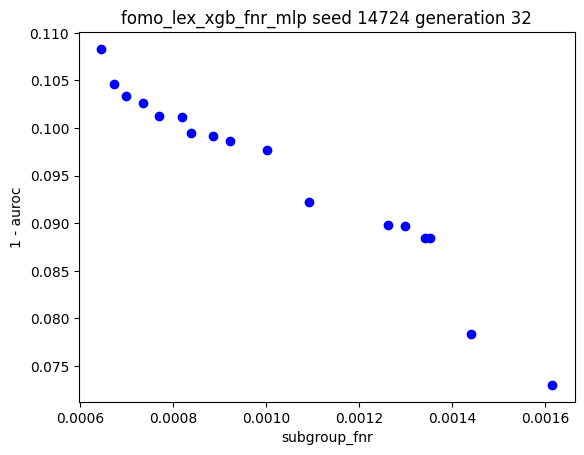

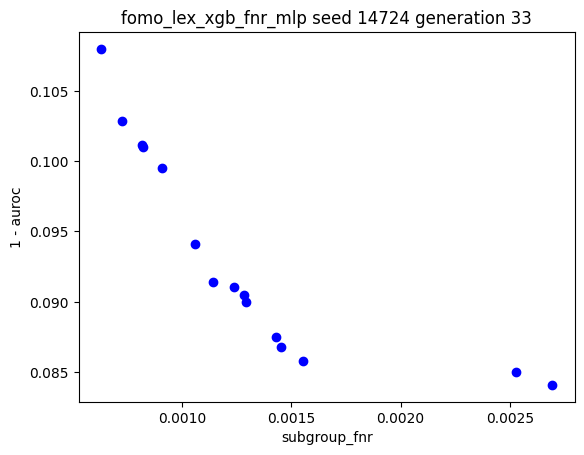

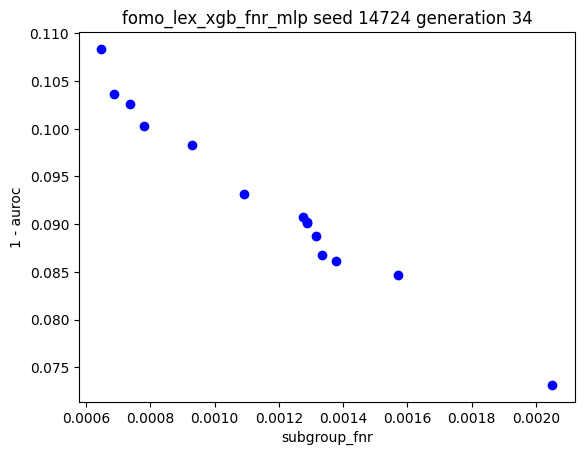

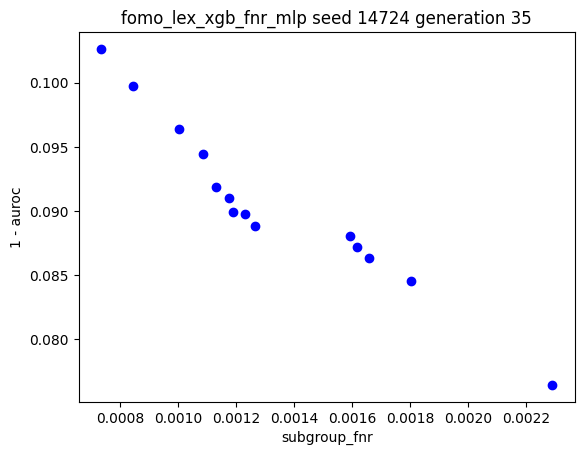

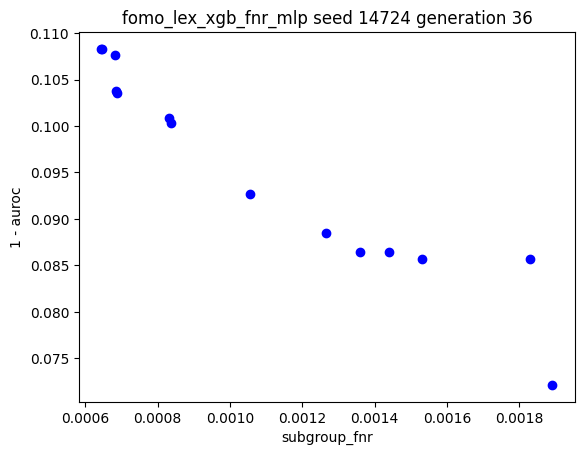

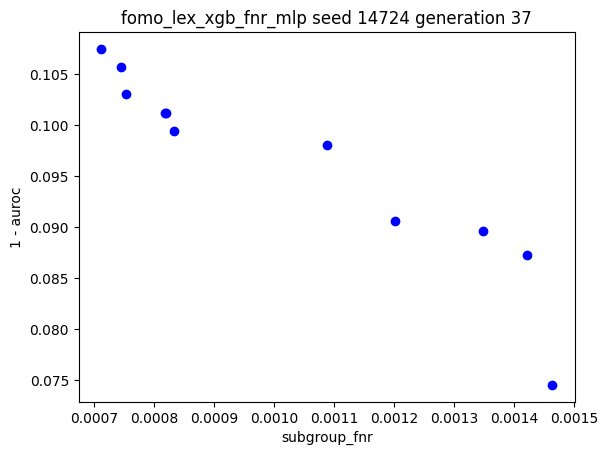

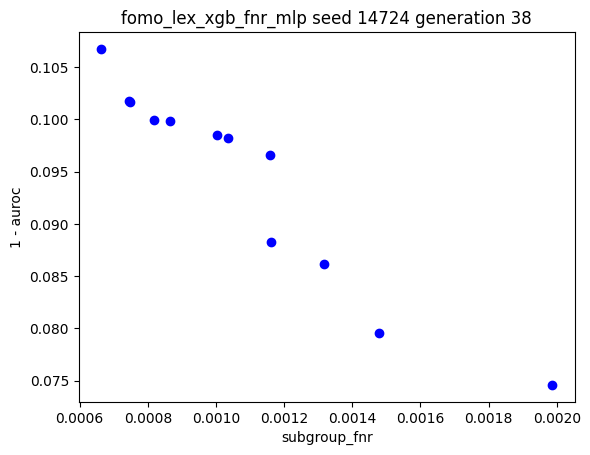

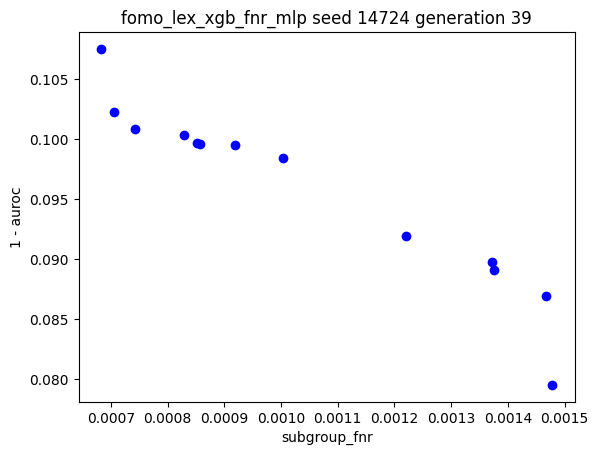

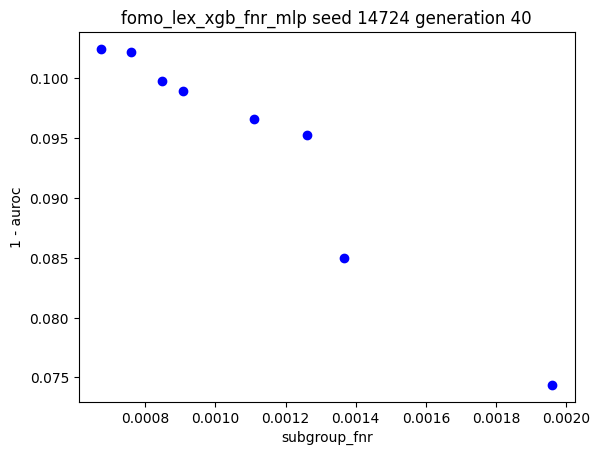

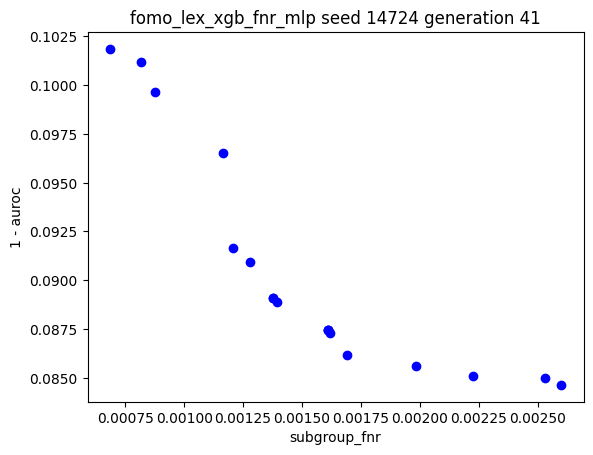

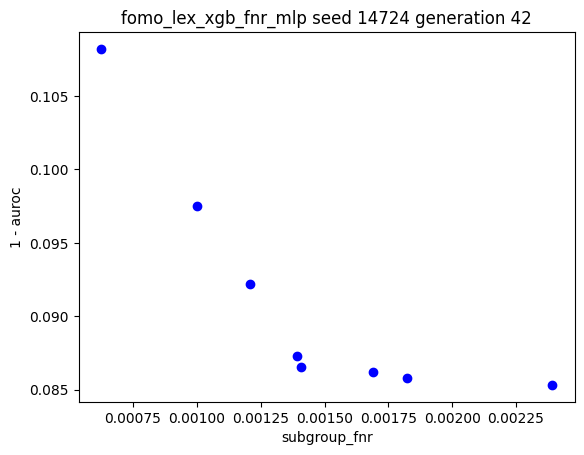

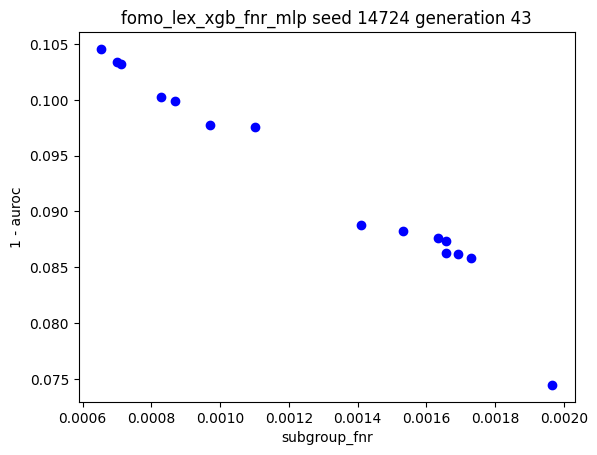

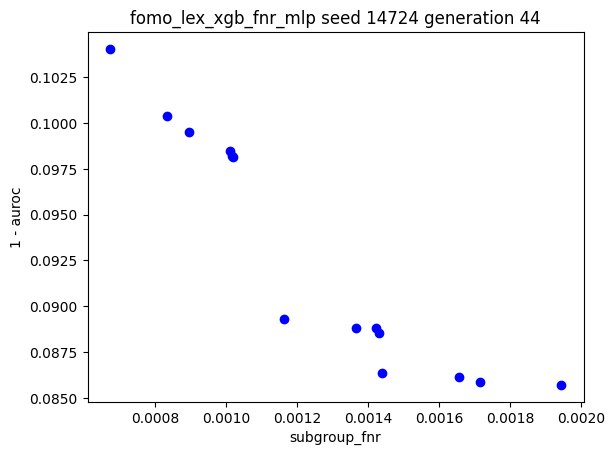

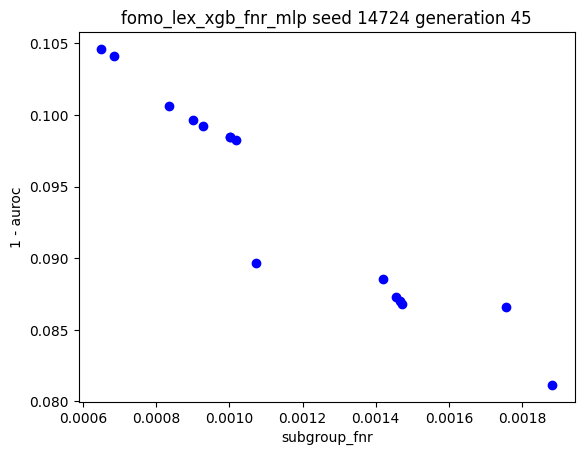

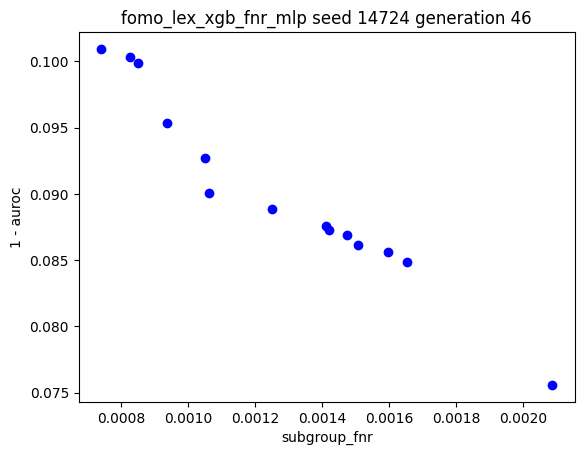

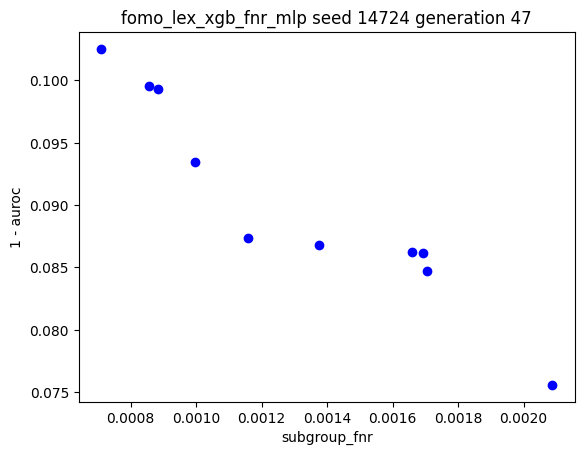

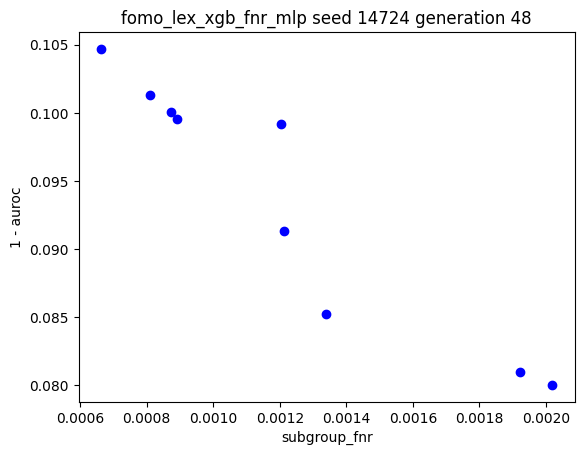

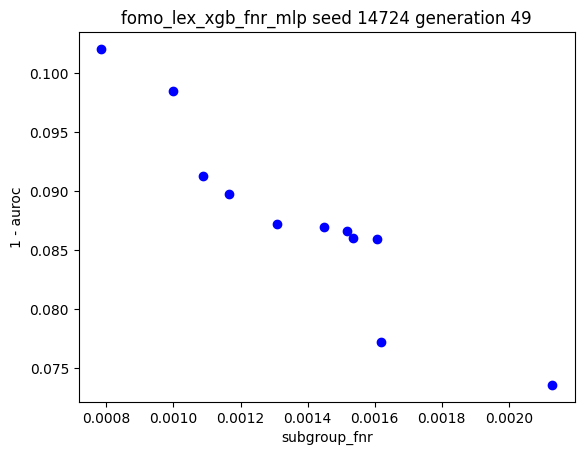

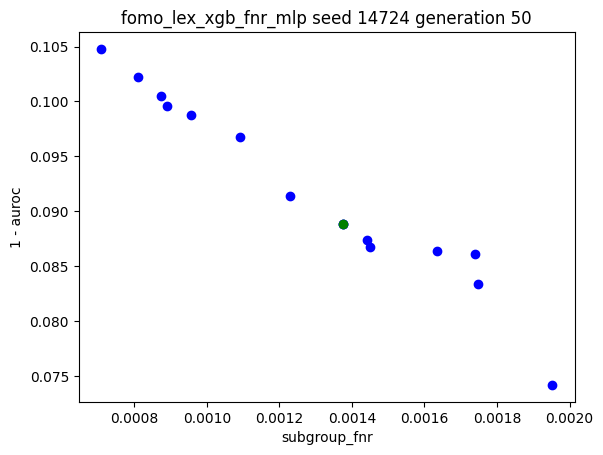

In [2]:
# Create pareto front for each generation   
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get a list of all the JSON files in the "pareto_history" folder
#rdir = '../results/Run_14/adult_normalized_2/pareto_history'
rdir = '../results/Run_15/synthetic1W/pareto_history'
json_files = [f for f in os.listdir(rdir) if f.endswith('.json')]

# Define a function to extract the generation number from a filename
def get_generation_number(filename):
    parts = filename.rsplit('_', 3)
    generation_number = parts[3].split('.')[0]  # Split on '.' and take the first part
    return int(generation_number)

# Sort the list of files by generation number
json_files = sorted(json_files, key=get_generation_number)

# Specify the desired model name and seed number
desired_model_name = 'fomo_lex_xgb_fnr_mlp'
desired_seed_number = '14724'


for json_file in json_files:
    # Split the filename into parts
    parts = json_file.rsplit('_', 3)
    model_name = parts[0]
    seed_number = parts[1]
    generation_number = parts[3].split('.')[0]

    if model_name == desired_model_name and seed_number == desired_seed_number:
        with open(os.path.join(rdir, json_file), 'r') as f:
            data = json.load(f)

        objectives = data['objectives']
        fngs = data['fngs']
        fn_values = data['fns']

        # Create a scatter plot from the objectives
        objectives_x = [obj[1] for obj in objectives]
        objectives_y = [obj[0] for obj in objectives]
        plt.scatter(objectives_x, objectives_y, color='blue')

        #Create a table from the fngs
        fngs_df = pd.DataFrame(fngs)
        fngs_df.columns = [f'Group {i+1}' for i in range(len(fngs[0]))]
        fngs_df.index = [f' {i+1}' for i in range(len(fngs))]
        fngs_df['overall fnr'] = fn_values

        #Find the solution with the lowest value for each group
        # min_indices = fngs_df.idxmin()
        
        # #Highlight the smallest value in each group
        # fngs_df = fngs_df.style.highlight_min(color='red')
        
        # #Highlight these solutions on the plot
        # for min_index in min_indices:
        #     min_index = int(min_index.split(' ')[1]) - 1  # Convert the index label to an integer index
        #     plt.scatter(objectives_x[min_index], objectives_y[min_index], color='red')
        if (generation_number == '50'):
            best_est_F = data['best_est_F']
            best_est_fng = data['best_est_fng']
            plt.scatter(best_est_F[1], 1+best_est_F[0], color='green')
            
        # Add labels to the points
        # for i, obj in enumerate(objectives):
        #     plt.text(obj[1], obj[0], f'{i+1}')

        plt.xlabel('subgroup_fnr')
        plt.ylabel('1 - auroc')
        plt.title(f'{model_name} seed {seed_number} generation {generation_number}')
        plt.show()

        #display(fngs_df)

In [ ]:
# print out the whole population for each generation as well as the solutions on the pareto front
# populations are printed out from pymoo.core.algorithm.py (json files with seed 100) and solutions are printed out from pymoo save_history=Ture
import os
import json
import pandas as pd

def parse_filename(filename):
    parts = filename.rsplit('_', 3)
    model_name = parts[0]
    seed = int(parts[1])
    generation = (parts[3].split('.')[0])
    return model_name, seed, generation

directory = '/home/shakiba/flex/results/Run_14/adult_normalized_2/populations'
data = []
selected_solutions = []

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        model_name, seed, generation = parse_filename(filename)
        with open(os.path.join(directory, filename)) as f:
            file_data = json.load(f)
        if (model_name == 'fomo_lex_lr_fnr_linear'):
            if seed == 100:
                for solution, fn in zip(file_data['fng'], file_data['fn']):
                    data.append([model_name, generation] + solution + [fn])
            elif seed == 14724:
                for solution, fn in zip(file_data['fngs'], file_data['fns']):
                    selected_solutions.append(solution + [fn])

df = pd.DataFrame(data, columns=['Model Name', 'Generation'] + [f'FNG {i+1}' for i in range(len(data[0])-2)])
df.rename(columns={df.columns[-1]: 'overall fnr'}, inplace=True)

def highlight_solutions(row):
    if row[1:].values.tolist() in selected_solutions:
        return ['background-color: yellow']*len(row)
    else:
        return ['']*len(row)

df.style.apply(highlight_solutions, axis=1)
df['Generation'] = df['Generation'].astype(int)
df = df.sort_values('Generation')
df = df.drop(columns=['Model Name'])

# Group by 'Generation'
grouped = df.groupby('Generation')

def highlight_min(s):
    if s.name in ['Model Name', 'Generation']:
        return ['']*len(s)
    #s = s.round(2)
    is_min = s <= s.min() + 0.001 #np.abs(np.median(s - s.median()))
    return ['background-color: red' if v else '' for v in is_min]

for name, group in grouped:
    group = group.reset_index(drop=True)
    group.index = group.index + 1
    display(group.style.apply(highlight_solutions, axis=1).apply(highlight_min))

In [19]:
# print out population in each generation that goes for selection and the selected parents
# This data comes from fomo.algorithm.py

import os
import json
import pandas as pd

def parse_filename(filename):
    parts = filename.rsplit('_', 3)
    model_name = parts[0]
    seed = int(parts[1])
    generation = (parts[3].split('.')[0])
    return model_name, seed, generation

directory = '/home/shakiba/flex'
pop_data = []
parent_data = []

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        model_name, seed, generation = parse_filename(filename)
        with open(os.path.join(directory, filename)) as f:
            file_data = json.load(f)
        if (model_name == 'fomo_lex_lr_fnr_linear'):
            population = file_data['pop']
            parents = file_data['parents']
            for pop, id in zip(population['fng'], population['id']):
                pop_data.append([model_name, generation] + pop + [id])
            for parent, id in zip(parents['fng'], parents['id']):
                parent_data.append(parent + [id])


df = pd.DataFrame(pop_data, columns=['Model Name', 'Generation'] + [f'FNG {i+1}' for i in range(len(pop_data[0])-2)])
df.rename(columns={df.columns[-1]: 'id'}, inplace=True)
            
def highlight_solutions(row):
    if row[1:].values.tolist() in parent_data:
        return ['background-color: yellow']*len(row)
    else:
        return ['']*len(row)

df.style.apply(highlight_solutions, axis=1)
df['Generation'] = df['Generation'].astype(int)
df = df.sort_values('Generation')
df = df.drop(columns=['Model Name'])

# Group by 'Generation'
grouped = df.groupby('Generation')

def highlight_min(s):
    if s.name in ['Model Name', 'Generation', 'id']:
        return ['']*len(s)
    #s = s.round(2)
    is_min = s <= s.min() + 0.001 #np.abs(np.median(s - s.median()))
    return ['background-color: red' if v else '' for v in is_min]

for name, group in grouped:
    group = group.reset_index(drop=True)
    group.index = group.index + 1
    display(group.style.apply(highlight_solutions, axis=1).apply(highlight_min))


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,2,0.153294,0.167729,0.127981,0.340974,140381806688960
2,2,0.187326,0.178911,0.148759,0.393753,140381806688336
3,2,0.223030,0.182883,0.168193,0.442837,140381806688480
4,2,0.166259,0.200603,0.155165,0.321792,140381806688528
5,2,0.143371,0.174137,0.125592,0.329143,140381806688624
6,2,0.186637,0.229515,0.180694,0.333984,140381806688672
7,2,0.179429,0.148360,0.126350,0.412567,140381806688720
8,2,0.146132,0.179141,0.125881,0.352415,140381806688768
9,2,0.202713,0.167290,0.146858,0.440903,140381806688816
10,2,0.170120,0.158360,0.127373,0.392556,140381806688864


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,3,0.139535,0.177507,0.124706,0.326680,140381807286624
2,3,0.137564,0.183053,0.127027,0.318947,140381807289072
3,3,0.173584,0.189040,0.148014,0.365459,140381807001856
4,3,0.166275,0.156054,0.124016,0.389844,140381807287968
5,3,0.169986,0.193187,0.154345,0.323304,140381807287872
6,3,0.304557,0.248118,0.253113,0.461652,140381807287824
7,3,0.173602,0.190109,0.148639,0.364632,140381807287728
8,3,0.169585,0.186599,0.144676,0.361622,140381807287680
9,3,0.185543,0.181134,0.150806,0.379760,140381807287632
10,3,0.170808,0.180087,0.141425,0.369115,140381807287584


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,4,0.175585,0.182916,0.147803,0.359310,140381807281584
2,4,0.133395,0.188087,0.129440,0.299860,140381807294448
3,4,0.189916,0.177881,0.149591,0.397288,140381807294496
4,4,0.182202,0.184905,0.151611,0.370467,140381807294976
5,4,0.293648,0.258955,0.255424,0.429320,140381807294640
6,4,0.165357,0.205338,0.156691,0.321255,140381807294688
7,4,0.132828,0.183257,0.127591,0.295737,140381807294736
8,4,0.167401,0.199889,0.155914,0.320413,140381807294784
9,4,0.145311,0.171491,0.128382,0.314050,140381807294832
10,4,0.304651,0.236499,0.246884,0.468562,140381807294880


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,5,0.169438,0.185688,0.147309,0.343009,140382562981136
2,5,0.142084,0.171126,0.125978,0.313437,140382562982384
3,5,0.173231,0.191285,0.156210,0.321267,140381806689440
4,5,0.176214,0.197481,0.157988,0.339786,140382562981376
5,5,0.140035,0.172035,0.126050,0.306565,140382562981328
6,5,0.167563,0.187714,0.147923,0.336594,140382562981280
7,5,0.181595,0.182795,0.150984,0.366049,140382562981232
8,5,0.167318,0.187952,0.148071,0.335283,140382562981040
9,5,0.186436,0.182549,0.154331,0.366430,140382562980992
10,5,0.172949,0.189202,0.154322,0.325786,140382562980944


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,6,0.178496,0.191750,0.158791,0.329873,140381807293872
2,6,0.183347,0.183087,0.155052,0.350261,140381807293824
3,6,0.180117,0.189055,0.158422,0.331992,140381807293776
4,6,0.142509,0.170452,0.125775,0.314707,140381807294304
5,6,0.136647,0.175612,0.127006,0.295660,140381807294064
6,6,0.150276,0.166194,0.125030,0.341442,140381807294016
7,6,0.178586,0.192081,0.159010,0.329828,140381807296368
8,6,0.185188,0.177005,0.147100,0.389381,140381807293920
9,6,0.179916,0.181912,0.148861,0.369078,140381807296128
10,6,0.179644,0.189877,0.158743,0.330208,140381807293584


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,7,0.179230,0.189929,0.157211,0.337631,140381807295744
2,7,0.182709,0.189779,0.160408,0.333290,140382562982000
3,7,0.194220,0.178390,0.156229,0.377844,140382563257120
4,7,0.180026,0.190348,0.158013,0.337407,140382563257168
5,7,0.177912,0.184362,0.152518,0.345192,140382563257216
6,7,0.185306,0.183210,0.156438,0.350812,140382563257264
7,7,0.131192,0.180260,0.127292,0.282624,140382563257312
8,7,0.195201,0.178023,0.156607,0.378868,140382563257360
9,7,0.132606,0.181389,0.130743,0.271227,140382563257408
10,7,0.179289,0.192221,0.155466,0.354215,140382563257456


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,8,0.318673,0.278776,0.283237,0.424219,140382563263744
2,8,0.169841,0.185497,0.147391,0.343760,140382563263936
3,8,0.315834,0.275283,0.279777,0.423350,140382563263840
4,8,0.186438,0.176398,0.147444,0.391145,140382563263792
5,8,0.185568,0.184082,0.157412,0.348452,140382563263696
6,8,0.187834,0.185277,0.159626,0.348223,140382563263360
7,8,0.178252,0.190753,0.158823,0.326028,140382563263600
8,8,0.181394,0.193867,0.162832,0.323956,140382563263504
9,8,0.174018,0.188313,0.153935,0.330354,140382563263456
10,8,0.192727,0.180818,0.158348,0.365214,140382563263408


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,9,0.130957,0.182770,0.130986,0.266300,140382563567024
2,9,0.179487,0.193460,0.161565,0.322184,140382563566928
3,9,0.178852,0.195281,0.157340,0.349236,140382563566976
4,9,0.176023,0.195424,0.156202,0.344161,140381806689488
5,9,0.144430,0.168285,0.126409,0.313561,140382563565920
6,9,0.187713,0.185987,0.159203,0.352065,140382563565872
7,9,0.143495,0.168775,0.126473,0.310430,140382563565824
8,9,0.176444,0.198243,0.158329,0.340753,140382563565776
9,9,0.177560,0.199242,0.159411,0.341767,140382563565728
10,9,0.178061,0.184251,0.152676,0.344607,140382563565680


,Generation,FNG 1,FNG 2,FNG 3,FNG 4,id
1,10,0.187893,0.185124,0.159651,0.347927,140382563571440
2,10,0.146830,0.166577,0.126200,0.320671,140382563571392
3,10,0.187816,0.185610,0.160091,0.346265,140382563571296
4,10,0.130597,0.182991,0.131024,0.265100,140382563571248
5,10,0.178582,0.196361,0.163473,0.314570,140382563571200
6,10,0.131050,0.182625,0.130961,0.266465,140382562988528
7,10,0.142891,0.169110,0.126540,0.308315,140382563571104
8,10,0.178351,0.195146,0.162464,0.316378,140382563571008
9,10,0.178788,0.196109,0.163399,0.315243,140382563570960
10,10,0.143507,0.168923,0.126455,0.310979,140382563570864
